In [1]:
from molsim import MolecularDynamics
import matplotlib.pyplot as plt
import numpy as np

# Molecular Dynamics techniques

### Initialize Molecular Dynamics system

The MD program consists of a main MolecularDynamics object, found in `src/molecularDynamics/md.h`. The object has a constructor, that allows you to set a bunch of different settings that you might want to use in this simulation. Furthermore you will find the thermostats in `src/molecularDynamics/thermostats.h` and some samplers in `src/molecularDynamics/samplers.h`.

### MolecularDynamics object
The `MolecularDynamics` struct has a bunch of different functions. First there is the constructor `MolecularDynamics::MolecularDynamics`, which, from the input settings, sets up the simulation. First it precomputes some properties, like volume and density. Secondly, it initializes the velocities according the Maxwell-Boltzmann distribution (note that because mass = 1, in this case and therefore momentum = velocity). 

It also initializes all positions on a cubic lattice by calling `MolecularDynamics::latticeInitialization`, which prevents overlaps from happening, but a further minimization to the closest local minimum is done by `MolecularDynamics::gradientDescent`.

### Force calculation
In MD one propagates the system by integrating the equations of motion. The integrator used for the equations of motion is the velocity Verlet integrator, which is a symplectic integrator. This means that the Hamiltonian is conserved, or, in other words, the drift or error in the ideally constant Hamiltonian is bounded. The Hamiltonian for an NVE system is (settings $m=1$)

$\mathcal{H}(p, q) = \sum_i^{N} \frac{p_i^2}{2} + \mathcal{U}(q)$

yielding the equations of motion:

$\dot{q} = \frac{\partial \mathcal{H}}{\partial p} = \frac{p}{m}$

$\dot{p} = -\frac{\partial \mathcal{H}}{\partial q} = -\frac{\partial \mathcal{U}}{\partial q}$.

In the velocity verlet algorithm these equations of motion are governed by updating the velocity in two half steps, once with the forces at time $t$ and once with the forces at time $t+\Delta t$.

This leads to integration scheme:

$v(t + \frac{\Delta t}{2}) = v(t) + F(t) \frac{\Delta t}{2}$

$q(t + \Delta t) = q(t) + v(t) \Delta t + F(t) \frac{(\Delta t)^2}{2}$

$v(t + \Delta t) = v(t + \frac{\Delta t}{2}) + F(t + \Delta t) \frac{\Delta t}{2}$

where

$F(t) = -\frac{\partial \mathcal{U}(q(t))}{\partial q}$.

In the code this force term is calculated in the method `MolecularDynamics::calculateForce`. This is the most computationally demanding function as it is a loop over all particle pairs. It can be nicely combined with computing the potential energy and the virial, which is used in the pressure. All particles have interaction with eachother according to the so-called Lennard-Jones potential - which has a repulsive term $r^{-12}$, which can be seen as the Pauli repulsion and an attraction term $r^{-6}$, which is often called the van der Waals term, as the van der Waals interaction also diminishes with $r^{-6}$. 

$\mathcal{U}(q) = \frac{1}{2} \sum_i^N \sum_j^N U_{LJ}(r_ij)$

where

$r_{ij} = |q_i - q_j|$

and 

$U_{LJ}(r_{ij}) = 4 \epsilon \left((\frac{\sigma}{r})^{12} - (\frac{\sigma}{r})^{6} \right)$.

### Velocity Verlet integrator

In [2]:

md = MolecularDynamics(
    numberOfParticles=200,
    temperature=1.0, 
    dt=0.005, 
    boxSize=8.0, 
    logLevel=0,
    seed=12,
    useNoseHoover=True,
    sampleFrequency=100
)
md.run(int(1e4), equilibrate=True, outputPDB=False)
md.run(int(1e5), equilibrate=False, outputPDB=True)

[INFO]:  Class MD created.
[DEBUG]:  Molecular Dynamics program
----------------------------
Number of particles  : 200
Temperature          : 1.000000
delta t              : 0.005000
Box length           : 8.000000
Density              : 0.390625
CutOff radius        : 3.000000
CutOff energy        : -0.005479
Steps run            : 0
Equilibration        : false
Observed temperature : 0.000000
Pressure             : 0.000000
Potential energy     : 0.000000
Kinetic energy       : 0.000000
Conserved energy     : 0.000000
Thermostat energy    : 0.011451
Drift energy         : nan


[DEBUG]:  (Init) initialized momenta.
[DEBUG]:  (Init) Zeroed momentum.
[INFO]:  numGrids 7 gridSize 0.888889
[DEBUG]:  (Init) initial energy: 3196.012650
[DEBUG]:  (Init) accepted gradient descent at step 0 energy difference = -1633.481022
[DEBUG]:  (Init) rejected gradient descent at step 1 energy difference = 1999.660998
[DEBUG]:  (Init) accepted gradient descent at step 2 energy difference = -542.837476
[

### Question 2

How is one able to control the temperature in this program? After all, the total energy of the
system should be constant (not the temperature)

### Question 3

To test the energy drift $\Delta E$ of the numerical integration
algorithm for a given time step $\Delta t$ after $N$ integration
steps, one usually computes

\begin{equation}
\Delta E\left(\Delta t\right) = \frac{1}{N} \sum_{i=1}^{i=N} \left|
\frac{E\left(0\right) - E\left(i\Delta t\right)}{E\left(0\right)}
\right|
\end{equation}

In this equation, $E\left(t\right)$ is the total energy
(kinetic+potential) of the system at time $t$. Change the program,
only in `MolecularDynamics::run`, in such a way that $\Delta E$
is computed and 
make a plot of $\Delta E$ as a function of the time step. To maintain
a certain energy drift, how does the time step have to change as a
function of the temperature and density?


### Question 4

REPLACE THIS QUESTION WITH ANOTHER PRECOMPUTATION OF (1/X)

As you might have noticed in the code, the implementation of the periodic boundary
conditions is often done as follows:
\begin{equation}
x = x - \text{box}*\text{nint}\left(x*\text{ibox}\right)
\end{equation}
where $\text{ibox}$ is used instead of $1/\text{box}$. Why would one do this?

### Question 5

An important quantity of a liquid or gas is the so-called self diffusivity $D$. There are two methods to calculate $D$:

##### By integrating the velocity autocorrelation function:

\begin{equation}
D = \frac{1}{3} \int_{0}^{\infty} \left\langle \bf{v}(t) \cdot \bf{v} \left(t+t^{'} \right) \right\rangle dt'
\end{equation}

or

\begin{equation}
D = \frac{ \int_{0}^{\infty} \sum_{i=1}^{i=N} \left\langle \bf{v}(i, t) \cdot \bf{v} \left(i, t+t^{'} \right) \right\rangle dt' }{3N}
\end{equation}

in which $N$ is the number of particles and ${\bf v}\left(i,t\right)$
is the velocity of particle $i$ at time $t$. One should choose $t$ in
such a way that independent time origins are taken, \emph{i.e.} $t =
ia\Delta t$, $i=1,2, \cdots , \infty$ and $\left\langle {\bf
v}\left(t\right)\cdot{\bf v}\left(t+a\Delta t\right)\right\rangle
\approx {\bf 0}$ (why?).

##### By calculating the mean square displacement:

\begin{equation}
D = \lim_{t' \to \infty} \frac{\left\langle \left| \bf{x}\left(t+t^{'}\right) - \bf{x}(t) \right|^{2} \right\rangle}{6t'}
\end{equation}

One should be very careful with the mean square displacement calculation when par-
ticles are always translated back to the central box – why?

##### Modify the program such that
the self diffusivity can be
calculated using both methods. Only modifications in subroutine `SampleMSD::sample` are needed. Why is it important to use only independent time origins for the calculation of the mean square displacement and the velocity autocorrelation function? What is the unit of $D$ in SI units? How can one transform $D$ into dimensionless units?


### Question 6

For Lennard-Jones liquids, Naghizadeh and Rice report the
following equation for the self diffusivity (dimensionless units,
$T^* <1.0$ and $p^* <3.0$) 

\begin{equation}
{\rm ^{\rm 10}log}\left(D^* \right) = 0.05 + 0.07p^* - \frac{1.04 +
0.1p^*}{T^*}
\end{equation}

Try to confirm this equation with simulations. 

### Question 7

Instead of calculating the average potential $\left\langle U
\right\rangle$ directly, one can use the radial distribution function
$g\left(r\right)$. Derive an expression for $\left\langle U
\right\rangle$ using $g\left(r\right)$. Compare this calculation with
a direct calculation of the average energy. A similar method can be
used to compute the average pressure.

### Question 8

In the current version of the code, the equation of motion are
integrated by the Verlet algorithm. Make a plot of the energy drift
$\Delta U$ for the following integration algorithms:
- Euler (never use this one except here !!!)
- Verlet
- Velocity Verlet



In [3]:
rdf = md.rdfSampler.getResults()
msd = md.msdSampler.getResults()

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/fp/ppyff45x5cj4hj___g1kwp4w0000gn/T/ipykernel_69771/4034678714.py:3: SyntaxWarning: invalid escape sequence '\s'
  ax.set_xlabel("Distance, r / $\sigma$")


Text(0, 0.5, 'g(r) / -')

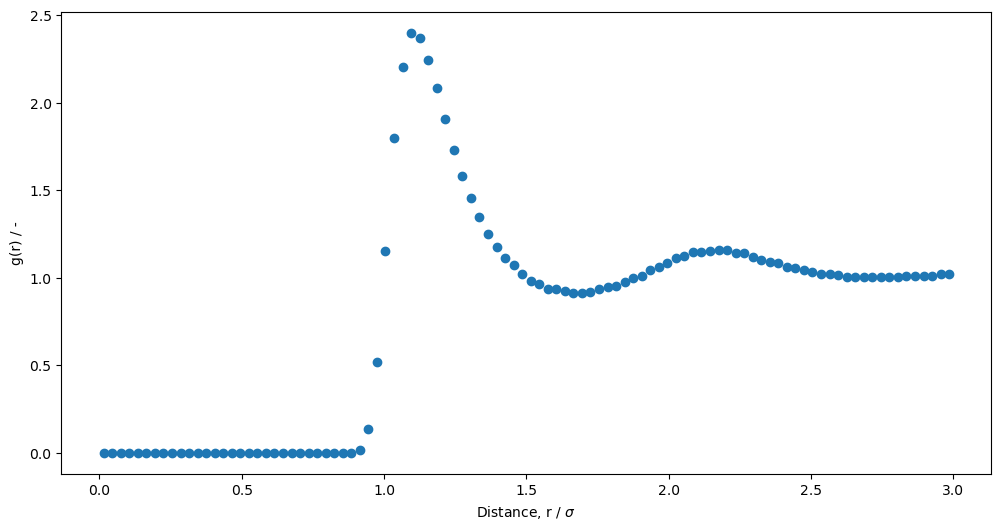

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(*rdf.T)
ax.set_xlabel("Distance, r / $\sigma$")
ax.set_ylabel("g(r) / -")

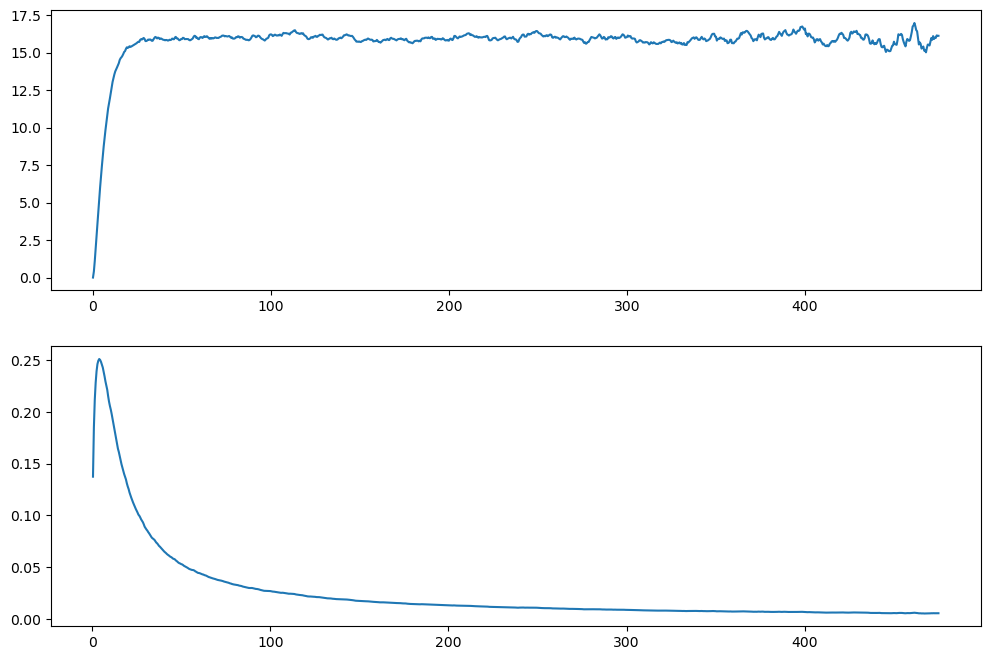

In [7]:
fig, ax = plt.subplots(2,figsize=(12,8))
ax[0].plot(msd[:, 0], msd[:, 1])
ax[1].plot(msd[:, 0], msd[:, 2])

<>:7: SyntaxWarning: invalid escape sequence '\i'
<>:7: SyntaxWarning: invalid escape sequence '\i'
/var/folders/fp/ppyff45x5cj4hj___g1kwp4w0000gn/T/ipykernel_69771/1308165336.py:7: SyntaxWarning: invalid escape sequence '\i'
  ax[1].set_ylabel("$\int$ d$t$ VACF")


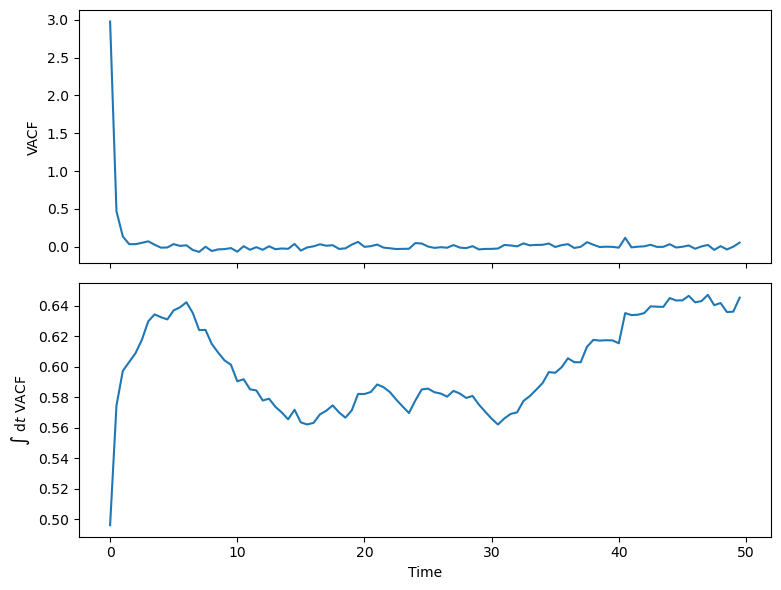

In [13]:
fig, ax = plt.subplots(2,figsize=(8,6), sharex=True)
ax[0].plot(msd[:100, 0], msd[:100, 3])
ax[1].plot(msd[:100, 0], msd[:100, 4])

ax[1].set_xlabel("Time")
ax[0].set_ylabel("VACF")
ax[1].set_ylabel("$\int$ d$t$ VACF")
fig.tight_layout()